# **Étude comparative entre la capitalisation et la répartition pour le système de retraite français (1985-2025)**

## **🔍 Objectif du projet**
Ce projet vise à comparer les performances d’un **système de retraite par capitalisation** avec le **système actuel par répartition** en France.  
L’objectif est de modéliser un **fonds souverain hypothétique**, où les cotisations des actifs seraient investies sur les marchés financiers, et d’analyser **les rendements et les pensions** qu’un tel système aurait pu fournir entre 1985 et 2025.

---

## **📈 Choix des indices**
### **Pourquoi comparer le CAC40 et le S&P500 ?**
Nous définissons **deux scénarios de référence** :
1. **Le CAC40 : un scénario conservateur**  
   - Il représente **l’économie française**, qui n’a pas bénéficié d’une capitalisation massive via des fonds de pension.
   - Si un **fonds souverain français** avait été instauré dès 1985, la capitalisation du CAC40 aurait logiquement été renforcée.

2. **Le S&P500 : un scénario optimiste**  
   - Il est **déjà massivement soutenu par des fonds de pension américains**.
   - Il permet **d’estimer ce que pourrait être un CAC40 dans un modèle capitalisé performant**.

💡 **Pourquoi cette comparaison ?**  
Cette approche permet d’avoir **une fourchette réaliste** entre un scénario prudent (**le CAC40**) et une projection optimiste (**le S&P500**), illustrant ce qu’un système capitalisé aurait pu générer en France.

---

### **🔗 Rôle des autres indices**
- **Le WGBI (World Government Bond Index)** est utilisé comme **référence obligataire** pour la partie obligations des portefeuilles.

---

## **📊 Méthodologie**
### **1️⃣ Collecte et prétraitement des données**
- Récupération des historiques du **CAC40, S&P500 et WGBI**.
- **Reconstruction des données manquantes (backfill)** pour garantir une continuité temporelle.
- **Calcul des variations mensuels** pour assurer le backtest des diférents portefeuils.

### **2️⃣ Simulation des allocations**
Nous modélisons **4 portefeuilles types**, répartis de la manière suivante :
- **50% actions / 50% obligations** (CAC40/WGBI et S&P500/WGBI).
- **75% actions / 25% obligations** (CAC40/WGBI et S&P500/WGBI).

**Hypothèse clé** : Les cotisations mensuelles sont **progressivement investies** dans ces portefeuilles (**DCA – Dollar Cost Averaging**).

 **Frais de gestion** : Un taux de 0,5% annuel de frais à été pris en compte, ce taux est un juste milieux entre les taux appliquées dans les différentes formes de fonds (souverain, ETF, PE et)

### **3️⃣ Calcul des rendements et pensions**
- **Estimation des rendements annualisés** des différentes allocations.
- **Détermination du taux de prélèvement optimal** pour garantir une pension stable sur **25 ans**, en cohérence avec l’espérance de vie moyenne des retraités.
- Ce taux permet de **maximiser les retraits** tout en assurant la viabilité du fonds.

### **4️⃣ Prise en compte de la solidarité**
- **Intégration des dispositifs de solidarité retraite** (ASPA, ASV) pour les bénéficiaires n’ayant pas cotisé pleinement.
- **Ajustement du modèle** pour inclure ces coûts dans l’estimation des pensions viables.

### **5️⃣ Analyse des résultats**
- **Comparaison des pensions obtenues** avec celles du système actuel.
- **Évaluation de l’impact des différentes allocations** et des rendements observés.
- **Visualisation des performances** du fonds de retraite hypothétique.

---


In [19]:
import os

# Charger le chemin depuis le fichier texte
with open("../.path_repo.txt", "r") as f:
    path_repo = f.read().strip()

os.chdir(path_repo)

FileNotFoundError: [Errno 2] No such file or directory: '../.path_repo.txt'

In [20]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Import du dataset cleané et augmenté (backfill des valleurs manquantes)
df = pd.read_csv(r"data\processed\DataFrame_backfilled.csv",  index_col='Date', parse_dates=['Date'])

## 📌 Création des colonnes de variation

Afin de pouvoir calculer la performance des portefeuilles dans les étapes suivantes, nous créons des colonnes représentant la variation mensuelle de chaque indice.  
L’index du DataFrame étant basé sur des dates mensuelles, la variation est calculée par rapport au mois précédent pour chaque indice.

🔹 Ces variations permettront ensuite de simuler l’effet des performances mensuelles sur un capital investi, en les appliquant successivement au fil du temps (logique de capitalisation).

In [21]:
df['SP500_var'] = df['SP500_TR'].pct_change()
df['CAC40_var'] = df['CAC40_TR'].pct_change()
df['WGBI_var'] = df['WGBI_TR'].pct_change()
df

,SP500_TR,CAC40_TR,WGBI_TR,SP500_var,CAC40_var,WGBI_var
Date,,,,,,
1985-01-01,172.176132,692.288669,10000.000000,NaN,NaN,NaN
1985-02-01,180.194935,720.457778,10235.623791,0.046573,0.040690,0.023562
1985-03-01,181.992612,726.738050,9832.991278,0.009976,0.008717,-0.039336
1985-04-01,182.598183,728.870481,10019.526779,0.003327,0.002934,0.018970
1985-05-01,183.032920,730.405192,10250.878162,0.002381,0.002106,0.023090
...,...,...,...,...,...,...
2024-08-01,12086.490234,23179.092370,55630.313495,0.013064,-0.025147,0.000550
2024-09-01,12292.099609,23646.248645,56093.077188,0.017012,0.020154,0.008319
2024-10-01,12598.030273,23654.766305,55534.603307,0.024888,0.000360,-0.009956


## 📌 Création du DataFrame des salaires et cotisations mensuels

Les salaires médians de 1985 et 2025 sont extraits de l’INSEE. \
Entre ces deux dates, les salaires sont interpolés annuellement à l’aide d’un taux de croissance constant.  
Même principe pour les taux de cotisation. \
Cela permet de simuler l’évolution mensuelle des cotisations d’un salarié moyen (ou plus exactement salarié médian).

In [22]:
# Définir les salaires et les taux
salaire_1985 = 1156  # Salaire médian de 1985
salaire_2025 = 2735  # Salaire médian de 2025
taux_1985 = 15.0  # Taux de cotisation en 1985
taux_2025 = 24.0  # Taux de cotisation en 2025

# Calcul du taux d'augmentation annuel pour le salaire
start_year = df.index.year.min()  # Récupérer l'année de début depuis l'index de ton DataFrame
end_year = df.index.year.max()  # Récupérer l'année de fin depuis l'index de ton DataFrame

# Calcul du taux d'augmentation annuel du salaire
taux_augmentation_annuel_salaire = (salaire_2025 / salaire_1985) ** (1 / (end_year - start_year)) - 1

# Calcul du taux d'augmentation annuel du taux de cotisation
taux_augmentation_annuel_cotisation = (taux_2025 / taux_1985) ** (1 / (end_year - start_year)) - 1

# Création des dates pour chaque année dans la période
dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

# Calcul du salaire mensuel pour chaque année
salaires = [salaire_1985 * (1 + taux_augmentation_annuel_salaire) ** (year - start_year) for year in range(start_year, end_year + 1)]

# Calcul du taux de cotisation pour chaque année
taux_cotisations = [taux_1985 * (1 + taux_augmentation_annuel_cotisation) ** (year - start_year) for year in range(start_year, end_year + 1)]

# Répéter les salaires et taux de cotisation pour chaque mois
salaire_mensuel = np.repeat(salaires, 12)
taux_cotisation_annuel = np.repeat(taux_cotisations, 12)

# Calcul des cotisations mensuelles
cotisations = salaire_mensuel * (taux_cotisation_annuel / 100)  # Conversion du taux de cotisation en pourcentage

# Création du DataFrame
salaire_df = pd.DataFrame({'Date': dates, 'salaire_mensuel': salaire_mensuel, 'taux_cotisation': taux_cotisation_annuel, 'cotisations': cotisations})

# Ajout de la colone des cotisations cumulées
salaire_df["cotisations_cumulees"] = salaire_df["cotisations"].cumsum()

# Affichage des premières lignes pour vérification
print(salaire_df)

          Date  salaire_mensuel  taux_cotisation  cotisations  \
0   1985-01-01           1156.0             15.0        173.4   
1   1985-02-01           1156.0             15.0        173.4   
2   1985-03-01           1156.0             15.0        173.4   
3   1985-04-01           1156.0             15.0        173.4   
4   1985-05-01           1156.0             15.0        173.4   
..         ...              ...              ...          ...   
475 2024-08-01           2735.0             24.0        656.4   
476 2024-09-01           2735.0             24.0        656.4   
477 2024-10-01           2735.0             24.0        656.4   
478 2024-11-01           2735.0             24.0        656.4   
479 2024-12-01           2735.0             24.0        656.4   

     cotisations_cumulees  
0              173.400000  
1              346.800000  
2              520.200000  
3              693.600000  
4              867.000000  
..                    ...  
475         172178.2899

In [23]:
# Fusionner les données de salaire avec les indices boursiers sur la date
df_ = salaire_df.merge(df[["SP500_var","CAC40_var","WGBI_var"]], on='Date', how='left')
df_.set_index("Date", inplace=True)
# Vérification
df_

,salaire_mensuel,taux_cotisation,cotisations,cotisations_cumulees,SP500_var,CAC40_var,WGBI_var
Date,,,,,,,
1985-01-01,1156.0,15.0,173.4,173.400000,NaN,NaN,NaN
1985-02-01,1156.0,15.0,173.4,346.800000,0.046573,0.040690,0.023562
1985-03-01,1156.0,15.0,173.4,520.200000,0.009976,0.008717,-0.039336
1985-04-01,1156.0,15.0,173.4,693.600000,0.003327,0.002934,0.018970
1985-05-01,1156.0,15.0,173.4,867.000000,0.002381,0.002106,0.023090
...,...,...,...,...,...,...,...
2024-08-01,2735.0,24.0,656.4,172178.289963,0.013064,-0.025147,0.000550
2024-09-01,2735.0,24.0,656.4,172834.689963,0.017012,0.020154,0.008319
2024-10-01,2735.0,24.0,656.4,173491.089963,0.024888,0.000360,-0.009956


## 📌 Simulation de la capitalisation

L’objectif de cette section est de modéliser ce qu’aurait pu générer un système de retraite par capitalisation, en supposant que les cotisations mensuelles n’avaient pas été immédiatement redistribuées, mais investies sur les marchés financiers.

### Approche en DCA (Dollar Cost Averaging) 🏦
Chaque mois, les cotisations sont investies progressivement dans un portefeuille financier au lieu d’être immédiatement reversées aux retraités.

### Mécanisme d’accumulation 💰
Chaque mois, la valeur du capital est mise à jour en appliquant la performance des indices correspondant à l’allocation choisie.  
Les cotisations suivantes s’ajoutent au capital déjà constitué, créant un effet de capitalisation renforcé par les intérêts composés.

### Frais de gestion 🔧
Pour garantir une approche réaliste dans ce scénario hypothétique, un taux de frais de gestion de 0,5 % a été retenu. \
Ce niveau constitue un bon compromis entre les très faibles frais des ETF (environ 0,1 %) et les frais parfois élevés des gestionnaires actifs privés (jusqu’à 2 %).
Étant donné que notre scénario repose sur un fonds public, un taux de 0,5 % paraît donc raisonnable et crédible.

In [24]:
# Paramètre : frais de gestion annuels
frais_annuels = 0.005  # 0.5% annuel
frais_mensuels = (1 + frais_annuels) ** (1/12) - 1

# Initialisation des colonnes
df_["CAC40_50/50"] = df_["cotisations"]
df_["SNP500_50/50"] = df_["cotisations"]
df_["CAC40_75/25"] = df_["cotisations"]
df_["SNP500_75/25"] = df_["cotisations"]

# Boucle mensuelle avec frais de gestion
for i in range(1, len(df_)):
    # CAC40 50/50
    prev_cac = df_.iloc[i - 1]["CAC40_50/50"]
    var = 0.5 * df_.iloc[i]["CAC40_var"] + 0.5 * df_.iloc[i]["WGBI_var"]
    df_.iloc[i, df_.columns.get_loc("CAC40_50/50")] = prev_cac * (1 + var - frais_mensuels) + df_.iloc[i]["cotisations"]

    # S&P500 50/50
    prev_snp = df_.iloc[i - 1]["SNP500_50/50"]
    var = 0.5 * df_.iloc[i]["SP500_var"] + 0.5 * df_.iloc[i]["WGBI_var"]
    df_.iloc[i, df_.columns.get_loc("SNP500_50/50")] = prev_snp * (1 + var - frais_mensuels) + df_.iloc[i]["cotisations"]

    # CAC40 75/25
    prev_cac = df_.iloc[i - 1]["CAC40_75/25"]
    var = 0.75 * df_.iloc[i]["CAC40_var"] + 0.25 * df_.iloc[i]["WGBI_var"]
    df_.iloc[i, df_.columns.get_loc("CAC40_75/25")] = prev_cac * (1 + var - frais_mensuels) + df_.iloc[i]["cotisations"]

    # S&P500 75/25
    prev_snp = df_.iloc[i - 1]["SNP500_75/25"]
    var = 0.75 * df_.iloc[i]["SP500_var"] + 0.25 * df_.iloc[i]["WGBI_var"]
    df_.iloc[i, df_.columns.get_loc("SNP500_75/25")] = prev_snp * (1 + var - frais_mensuels) + df_.iloc[i]["cotisations"]

# Vérification
print(df_[["CAC40_50/50", "SNP500_50/50", "CAC40_75/25", "SNP500_75/25"]])


              CAC40_50/50   SNP500_50/50    CAC40_75/25  SNP500_75/25
Date                                                                 
1985-01-01     173.400000     173.400000     173.400000  1.734000e+02
1985-02-01     352.298582     352.808675     353.041057  3.538062e+02
1985-03-01     520.158552     520.882757     525.130561  5.262270e+02
1985-04-01     699.039252     699.873493     701.958385  7.032172e+02
1985-05-01     880.955026     881.895746     880.227168  8.816398e+02
...                   ...            ...            ...           ...
2024-08-01  486505.729242  651282.684620  604967.359739  9.721647e+05
2024-09-01  493885.962470  659916.850345  615774.858068  9.868422e+05
2024-10-01  491967.384890  665225.917643  614808.934010  1.003053e+06
2024-11-01  491906.795392  674407.144408  604532.621589  1.007346e+06
2024-12-01  483700.976313  691611.590857  591075.727255  1.048784e+06

[480 rows x 4 columns]


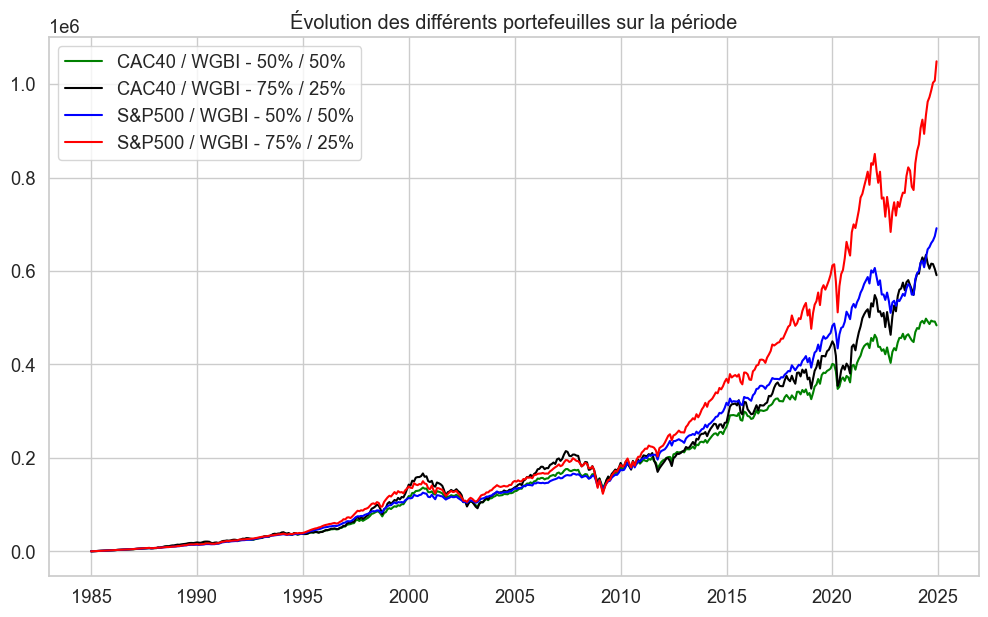

In [61]:
plt.figure(figsize=(12,7))
plt.plot(df_.index, df_["CAC40_50/50"], label="CAC40 / WGBI - 50% / 50%", color="green")
plt.plot(df_.index, df_["CAC40_75/25"], label="CAC40 / WGBI - 75% / 25%", color="black")
plt.plot(df_.index, df_["SNP500_50/50"], label="S&P500 / WGBI - 50% / 50%", color="blue")
plt.plot(df_.index, df_["SNP500_75/25"], label="S&P500 / WGBI - 75% / 25%", color="red")

plt.legend()
plt.title("Évolution des différents portefeuilles sur la période")
plt.savefig("charts/perf_portefeuilles.png", dpi=300, bbox_inches='tight')
plt.show()

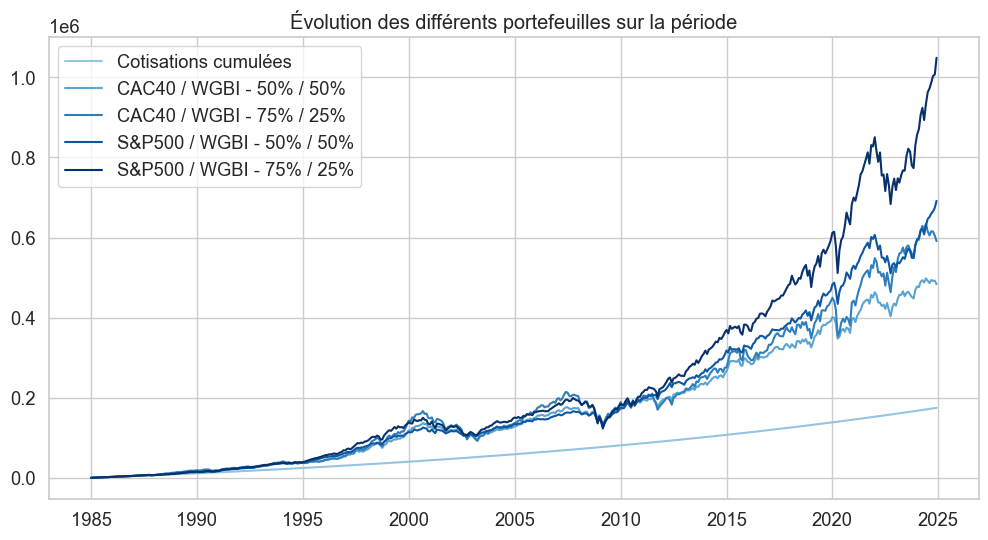

In [62]:
allocations = ['cotisations_cumulees', 'CAC40_50/50', 'CAC40_75/25', 'SNP500_50/50', 'SNP500_75/25']
colors = plt.cm.Blues(np.linspace(0.4, 1, len(allocations)))

plt.figure(figsize=(12,6))
plt.plot(df_.index, df_["cotisations_cumulees"], label="Cotisations cumulées", color=colors[0])
plt.plot(df_.index, df_["CAC40_50/50"], label="CAC40 / WGBI - 50% / 50%", color=colors[1])
plt.plot(df_.index, df_["CAC40_75/25"], label="CAC40 / WGBI - 75% / 25%", color=colors[2])
plt.plot(df_.index, df_["SNP500_50/50"], label="S&P500 / WGBI - 50% / 50%", color=colors[3])
plt.plot(df_.index, df_["SNP500_75/25"], label="S&P500 / WGBI - 75% / 25%", color=colors[4])

plt.legend()
plt.title("Évolution des différents portefeuilles sur la période")
plt.savefig("charts/perf_portefeuilles_blue.png", dpi=300, bbox_inches='tight')
plt.show()

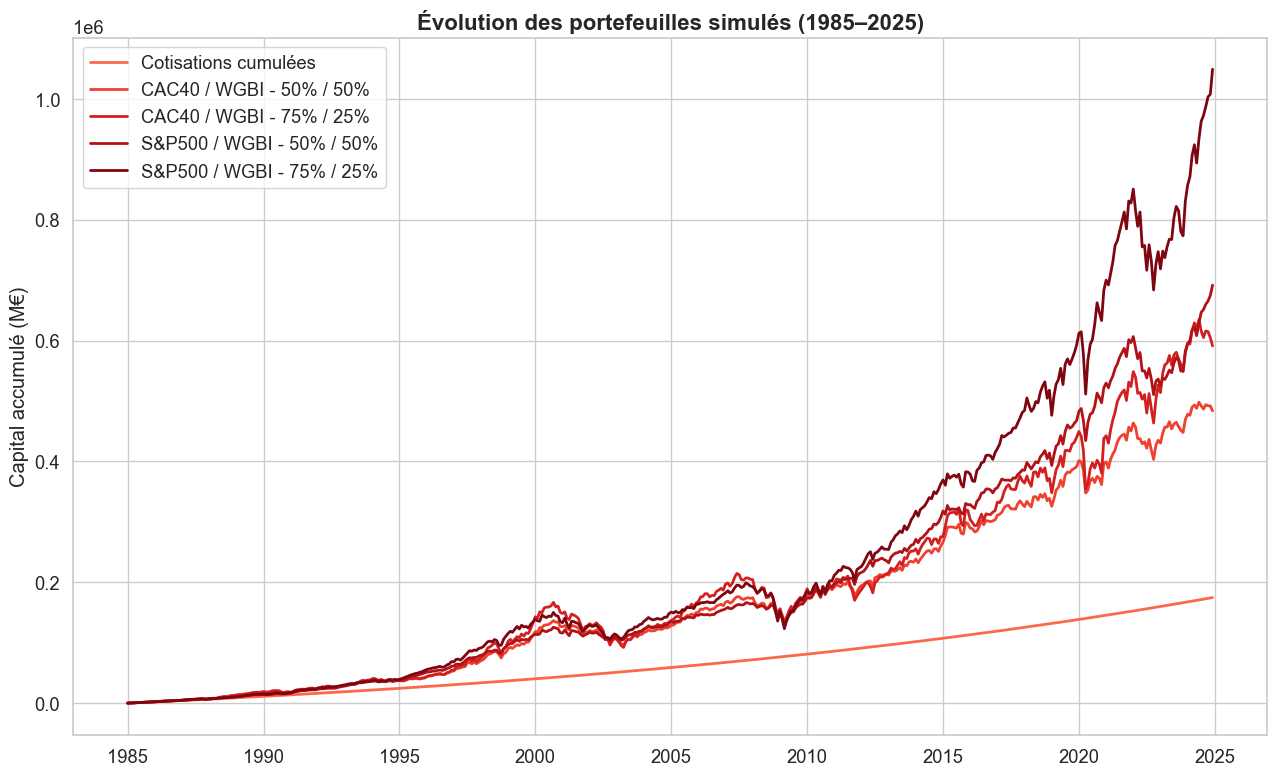

In [76]:
# Style Seaborn pro
sns.set(style="whitegrid", font_scale=1.2)

# Définir l'ordre des colonnes à tracer
allocations = ['cotisations_cumulees', 'CAC40_50/50', 'CAC40_75/25', 'SNP500_50/50', 'SNP500_75/25']
labels = ["Cotisations cumulées",
          "CAC40 / WGBI - 50% / 50%",
          "CAC40 / WGBI - 75% / 25%",
          "S&P500 / WGBI - 50% / 50%",
          "S&P500 / WGBI - 75% / 25%"]

# Couleurs (Rouge dégradé)
steps = np.linspace(0.5, 0.95, len(allocations))
reds_cmap = sns.color_palette("Reds", as_cmap=True)
colors = [reds_cmap(step) for step in steps]

# Création de la figure
plt.figure(figsize=(13, 8))

# Tracer chaque courbe avec la couleur et le label associés
for i, col in enumerate(allocations):
    sns.lineplot(data=df_, x=df_.index, y=col, label=labels[i], color=colors[i], linewidth=2)

# Titre et axes
plt.title("Évolution des portefeuilles simulés (1985–2025)", fontsize=16, fontweight='bold')
plt.xlabel("")
plt.ylabel("Capital accumulé (M€)")
plt.legend(loc="upper left")
plt.tight_layout()

# Sauvegarde HD
plt.savefig("charts/perf_portefeuilles_red.png", dpi=300, bbox_inches='tight')

# Affichage
plt.show()

## 📌 Résultat de la capitalisation :

À partir du DataFrame des simulations, nous extrayons et stockons dans des variables clés les montants finaux de capitalisation.  
Ces montants correspondent à la somme totale des cotisations versées, ainsi qu’à leur valorisation au fil du temps grâce aux rendements des marchés financiers.

🔹 Nous calculons ensuite des moyennes par type d’allocation (50/50, 75/25, etc.), ainsi qu’une moyenne générale tous portefeuilles confondus. \

Ces variables serviront de base aux comparaisons avec le système actuel par répartition.


In [27]:
# Récupérer la dernière valeur de chaque allocation
cumul_des_cotisations = df_["cotisations_cumulees"].iloc[-1]
cac_50_50_final = df_["CAC40_50/50"].iloc[-1]
cac_75_25_final = df_["CAC40_75/25"].iloc[-1]
snp_50_50_final = df_["SNP500_50/50"].iloc[-1]
snp_75_25_final = df_["SNP500_75/25"].iloc[-1]

# Afficher les résultats
print(f"Cumul des cotisations: {cumul_des_cotisations/1000:.0f} k€")
print(f"CAC40 50/50 final: {cac_50_50_final/1000:.0f} k€")
print(f"CAC40 75/25 final: {cac_75_25_final/1000:.0f} k€")
print(f"S&P500 50/50 final: {snp_50_50_final/1000:.0f} k€")
print(f"S&P500 75/25 final: {snp_75_25_final/1000:.0f} k€")
print()

mean_50_50 = np.mean([cac_50_50_final, snp_50_50_final])
mean_75_75 = np.mean([cac_75_25_final, snp_75_25_final])
print(f"Mean 50/50 final: {mean_50_50/1000:.0f} k€")
print(f"Mean 75/25 final: {mean_75_75/1000:.0f} k€")
print()

global_mean = np.mean([mean_50_50, mean_75_75])
print(f"Global mean final: {global_mean/1000:.0f} k€")


Cumul des cotisations: 175 k€
CAC40 50/50 final: 484 k€
CAC40 75/25 final: 591 k€
S&P500 50/50 final: 692 k€
S&P500 75/25 final: 1049 k€

Mean 50/50 final: 588 k€
Mean 75/25 final: 820 k€

Global mean final: 704 k€


In [28]:
# Export du DataFrame
df_.to_csv(r"data\final\backtest_retraites_capitalisation.csv", index=True, encoding="utf-8")

## 📌 Normalisation des indices

Nous construisons ici des indices normalisés pour comparer visuellement la performance relative des différents actifs (CAC40, S&P500, WGBI) sur la période étudiée.

🔹 Chaque indice est initialisé à une base 100 (ici représentée par 1.0) au début de la période.  
🔹 À chaque mois, la valeur précédente est multipliée par (1 + variation mensuelle), ce qui simule la croissance d’un capital fictif investi dans cet indice à partir de 1985.

Ce procédé permet de visualiser l’évolution comparée des indices sur une même échelle, indépendamment de leur valeur nominale initiale.

In [29]:
# Initialisation à 1 pour chaque colonne normalisée
df_['SP500_norm'] = 1.0
df_['CAC40_norm'] = 1.0
df_['WGBI_norm'] = 1.0

# Application des variations cumulées mois par mois
for i in range(1, len(df_)):
    df_.iloc[i, df_.columns.get_loc('SP500_norm')] = df_.iloc[i - 1, df_.columns.get_loc('SP500_norm')] * (
        1 + df_.iloc[i, df_.columns.get_loc('SP500_var')])
    df_.iloc[i, df_.columns.get_loc('CAC40_norm')] = df_.iloc[i - 1, df_.columns.get_loc('CAC40_norm')] * (
        1 + df_.iloc[i, df_.columns.get_loc('CAC40_var')])
    df_.iloc[i, df_.columns.get_loc('WGBI_norm')] = df_.iloc[i - 1, df_.columns.get_loc('WGBI_norm')] * (
        1 + df_.iloc[i, df_.columns.get_loc('WGBI_var')])

## 📌 Performance annualisée de nos portefeuilles

Nous calculons le rendement annuel composé pour chaque portefeuille (50/50 ou 75/25 entre actions et obligations).  
Cela permet de quantifier la performance sur 40 ans et de comparer les stratégies.

In [30]:
# Nombre d'années simulées
years = len(df_) / 12  # = 40 ans

# Calcul des rendements annualisés pour chaque portefeuille simulé
cac40_50_50_rdt = (((df_["CAC40_norm"].iloc[-1] / df_["CAC40_norm"].iloc[0]) * 0.5 +
                    (df_["WGBI_norm"].iloc[-1] / df_["WGBI_norm"].iloc[0]) * 0.5) ** (1 / years)) - 1
cac40_75_25_rdt = (((df_["CAC40_norm"].iloc[-1] / df_["CAC40_norm"].iloc[0]) * 0.75 +
                    (df_["WGBI_norm"].iloc[-1] / df_["WGBI_norm"].iloc[0]) * 0.25) ** (1 / years)) - 1
snp500_50_50_rdt = (((df_["SP500_norm"].iloc[-1] / df_["SP500_norm"].iloc[0]) * 0.5 +
                     (df_["WGBI_norm"].iloc[-1] / df_["WGBI_norm"].iloc[0]) * 0.5) ** (1 / years)) - 1
snp500_75_25_rdt = (((df_["SP500_norm"].iloc[-1] / df_["SP500_norm"].iloc[0]) * 0.75 +
                     (df_["WGBI_norm"].iloc[-1] / df_["WGBI_norm"].iloc[0]) * 0.25) ** (1 / years)) - 1


# Affichage
print(f"CAC40 50/50 annualisé : {cac40_50_50_rdt * 100:.2f}%")
print(f"CAC40 75/25 annualisé : {cac40_75_25_rdt * 100:.2f}%")
print(f"S&P500 50/50 annualisé : {snp500_50_50_rdt * 100:.2f}%")
print(f"S&P500 75/25 annualisé : {snp500_75_25_rdt * 100:.2f}%")


CAC40 50/50 annualisé : 7.62%
CAC40 75/25 annualisé : 8.43%
S&P500 50/50 annualisé : 9.75%
S&P500 75/25 annualisé : 10.74%


## 📌 Calcul du taux de retrait maximum

🔹 Il ne serait pas cohérent de comparer une retraite par répartition avec une retraite capitalisée fondée sur la simple règle des 4%, qui vise à préserver le capital.  
Dans un modèle de fonds souverain, l'objectif est d'épuiser progressivement le capital sur la durée de la retraite.  
Il est donc nécessaire de calculer un taux de retrait "optimal", maximisant les pensions tout en assurant une viabilité sur 25 ans.\
La durée de vie moyenne des retraités en France en 2024 est de 26,1 ans pour les femmes, et 23,3 ans pour les hommes, soit 24,7 en moyenne.
🔹 Par simplicité nous choisison le taux de retrais le plus faible (celui du sénario le plus conservateur), si on applique ce taux aux autres sénarios le montant sera donc surévaluer, mais nous pourrons simplement soustraire le résultat du taux de retrait le plus faible appliquer à son sénario aux autres pour obtenir la pension exacte.

## 📌 Calcul du taux de retrait maximum

🔹 Il ne serait pas pertinent de comparer une retraite par répartition avec une retraite capitalisée en appliquant la simple règle des 4 %, conçue pour préserver le capital à vie.  
Dans une logique de fonds souverain, l’objectif est au contraire d’utiliser le capital accumulé pour financer les pensions tout au long de la retraite, en l’épuisant progressivement.

🎯 L’objectif est donc de déterminer un **taux de retrait optimal**, c’est-à-dire le pourcentage du capital qu’un retraité peut percevoir chaque année, tout en s’assurant que celui-ci reste suffisant pendant toute la durée de la retraite.

📅 En 2024, la durée de vie moyenne à la retraite en France est estimée à :
- 26,1 ans pour les femmes,
- 23,3 ans pour les hommes,  
➡️ Soit une moyenne de **24,7 ans**.

In [31]:
withdrawal_years = 25

def safe_withdrawal_rate(annual_return, years):
    return annual_return / (1 - (1 + annual_return) ** -years)

cac40_50_50_swr = safe_withdrawal_rate(cac40_50_50_rdt, withdrawal_years)
cac40_75_25_swr = safe_withdrawal_rate(cac40_75_25_rdt, withdrawal_years)
snp500_50_50_swr = safe_withdrawal_rate(snp500_50_50_rdt, withdrawal_years)
snp500_75_25_swr = safe_withdrawal_rate(snp500_75_25_rdt, withdrawal_years)

print(f"CAC40 50/50 Safe withdrawal : {cac40_50_50_swr:.2%}")
print(f"CAC40 75/25 Safe withdrawal : {cac40_75_25_swr:.2%}")
print(f"S&P500 50/50 Safe withdrawal : {snp500_50_50_swr:.2%}")
print(f"S&P500 75/25 Safe withdrawal : {snp500_75_25_swr:.2%}")

# On sélectionne le pourcentage le plus prudent (le plus faible) et on l'arrondit à 7%
withdrawal_rate_selected = min(cac40_50_50_swr, cac40_75_25_swr, snp500_50_50_swr, snp500_75_25_swr)
print()
print(f"Taux de prélèvement sélectionné : {withdrawal_rate_selected:.2%}")


CAC40 50/50 Safe withdrawal : 9.07%
CAC40 75/25 Safe withdrawal : 9.72%
S&P500 50/50 Safe withdrawal : 10.81%
S&P500 75/25 Safe withdrawal : 11.65%

Taux de prélèvement sélectionné : 9.07%


## 📌 Retraite moyenne et retraite médiane en France

Selon le rapport annuel de la **DREES** (Direction de la Recherche, des Études, de l’Évaluation et des Statistiques)\[1\], \
la **pension moyenne brute de droit direct**, incluant la majoration pour trois enfants ou plus, \
s’élevait à **1 626 € bruts mensuels** en décembre 2022, pour les nouveaux retraités résidant en France.

🔹 Ce montant servira de **référence comparative** tout au long de l’étude, afin d’évaluer la performance des pensions issues d’un système capitalisé simulé.

\[1\] *DREES, Les retraités et les retraites – édition 2023.*


In [32]:
# Montant de la pension retraite brute médiane en France en 2022 :
retraite_actuelle = 1626

# Calcul du montant des cotisations
cac_50_50_pension = cac_50_50_final * withdrawal_rate_selected / 12
cac_75_25_pension = cac_75_25_final * withdrawal_rate_selected / 12
snp_50_50_pension = snp_50_50_final * withdrawal_rate_selected / 12
snp_75_25_pension = snp_75_25_final * withdrawal_rate_selected / 12

print(f"Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 50/50 : {int(cac_50_50_pension)}€")
print(f"Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 75/20 : {int(cac_75_25_pension)}€")
print(f"Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 50/50 : {int(snp_50_50_pension)}€")
print(f"Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 75/75 : {int(snp_75_25_pension)}€")

Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 50/50 : 3655€
Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 75/20 : 4466€
Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 50/50 : 5226€
Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 75/75 : 7925€


## 📌 Intégration des prestations de solidarité

Les estimations de pensions mensuelles calculées jusqu'ici **n’incluent pas** les dispositifs de solidarité comme l’**ASPA** (Allocation de Solidarité aux Personnes Âgées) et l’**ASV** (Allocation Supplémentaire du Minimum Vieillesse), versés aux retraités ayant peu ou pas cotisé.

🔹 Pour évaluer la viabilité d’un système capitalisé, il est important d’estimer le **coût global de ces prestations**, afin de simuler leur prise en charge par un mécanisme solidaire intégré à la capitalisation.

### 📊 Données clés :

- **801 000 bénéficiaires** du minimum vieillesse fin 2023  
  - Dont **594 000** pour l’ASPA  
  - Et **117 000** pour l’ASV  
- **Montants moyens mensuels** en 2022 :  
  - **495 € pour l’ASPA**  
  - **440 € pour l’ASV**  
- **Nombre total de retraités** en France : environ **17 millions**  
  - Dont **15,3 millions** affiliés au **régime général**
  
### 📈 Hypothèse d’intégration au modèle :

En l’absence de données individuelles précises, nous estimons un coût global basé sur l’hypothèse que tous les bénéficiaires actuels n’auraient **aucun capital accumulé** dans un système par capitalisation.  
Or, en réalité, une **part importante de ces retraités a probablement cotisé partiellement** au cours de leur carrière, ce qui signifie qu’ils auraient accumulé un capital partiel.  

➡️ Notre estimation constitue donc une **surestimation prudente** du coût réel de la solidarité dans un modèle capitalisé. Elle permet néanmoins d’évaluer un **ordre de grandeur** réaliste et d’envisager l’inclusion d’un **filet de sécurité minimal**, sans remettre en cause l’équilibre du système.

In [33]:
ASPA_2023 = 594_000*495*12
ASV_2023 = 117_000*440*12
solidaritée_2023_milliards = (ASPA_2023 + ASV_2023) / 1_000_000_000
print(f"Montant des solidaritées retraites en 2023 environ = {int(solidaritée_2023_milliards)} Milliards")

nbr_retraites_2022 = 17_000_000
capi_aproximative_milliards = nbr_retraites_2022 * retraite_actuelle / 1_000_000_000
print(f"Montant total versé aux retraites en 2023 environ = {int(capi_aproximative_milliards)} Milliards")

print()
capi_total_cac_50_50 = cac_50_50_final * nbr_retraites_2022
print(f"Capitalisation total du fond CAC 40 50/50 = {int(capi_total_cac_50_50 / 1_000_000_000)} Milliards")
capi_total_snp_75_25 = snp_75_25_final * nbr_retraites_2022
print(f"Capitalisation total du fond S&P 500 75/25 = {int(capi_total_snp_75_25 / 1_000_000_000)} Milliards")
print()

# Taux de solidarité nécessaire (automatique)
taux_solidarité_dynamique = (solidaritée_2023_milliards * 1e9) / (cac_50_50_pension * 12 * nbr_retraites_2022)

print(f"Taux de solidarité (à déduire des pensions) = {round(taux_solidarité_dynamique*100,2)} %")

Montant des solidaritées retraites en 2023 environ = 4 Milliards
Montant total versé aux retraites en 2023 environ = 27 Milliards

Capitalisation total du fond CAC 40 50/50 = 8222 Milliards
Capitalisation total du fond S&P 500 75/25 = 17829 Milliards

Taux de solidarité (à déduire des pensions) = 0.56 %


## 📌 Réévaluation des pensions mensuelles

Nous recalculons désormais les pensions mensuelles en intégrant la contribution de solidarité estimée précédemment.

🔹 Cette réévaluation permet de simuler un système de retraite par capitalisation **intégrant une dimension redistributive**, en prenant en compte le coût approximatif des prestations minimales (ASPA, ASV).

Cela permet d'obtenir une estimation plus complète et plus réaliste des pensions nettes de solidarité, telles qu’elles pourraient être versées dans un modèle hybride.

In [34]:
# Calcul du montant des cotisations
cac_50_50_solidaire = cac_50_50_pension - (cac_50_50_pension*taux_solidarité_dynamique)
cac_75_25_solidaire = cac_75_25_pension - (cac_50_50_pension*taux_solidarité_dynamique)
snp_50_50_solidaire = snp_50_50_pension - (cac_50_50_pension*taux_solidarité_dynamique)
snp_75_25_solidaire = snp_75_25_pension - (cac_50_50_pension*taux_solidarité_dynamique)

print("RESULTATS FINAUX :")
print(f"Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 50/50 (solidaritée déduite) : {int(cac_50_50_solidaire)}€")
print(f"Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 75/20 (solidaritée déduite) : {int(cac_75_25_solidaire)}€")
print(f"Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 50/50 (solidaritée déduite) : {int(snp_50_50_solidaire)}€")
print(f"Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 75/75 (solidaritée déduite) : {int(snp_75_25_solidaire)}€")

RESULTATS FINAUX :
Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 50/50 (solidaritée déduite) : 3634€
Pension mensuelle pour l'allocation CAC 40 / Wordl Bonds 75/20 (solidaritée déduite) : 4446€
Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 50/50 (solidaritée déduite) : 5205€
Pension mensuelle pour l'allocation S&P 500 / Wordl Bonds 75/75 (solidaritée déduite) : 7904€


## 📌 Comparaison visuelle des pensions mensuelles

Les graphiques suivants comparent les pensions générées par les différentes allocations de portefeuille avec la pension médiane actuelle issue du système par répartition.  
La ligne rouge indique le niveau de référence du système actuel (1 626 €).

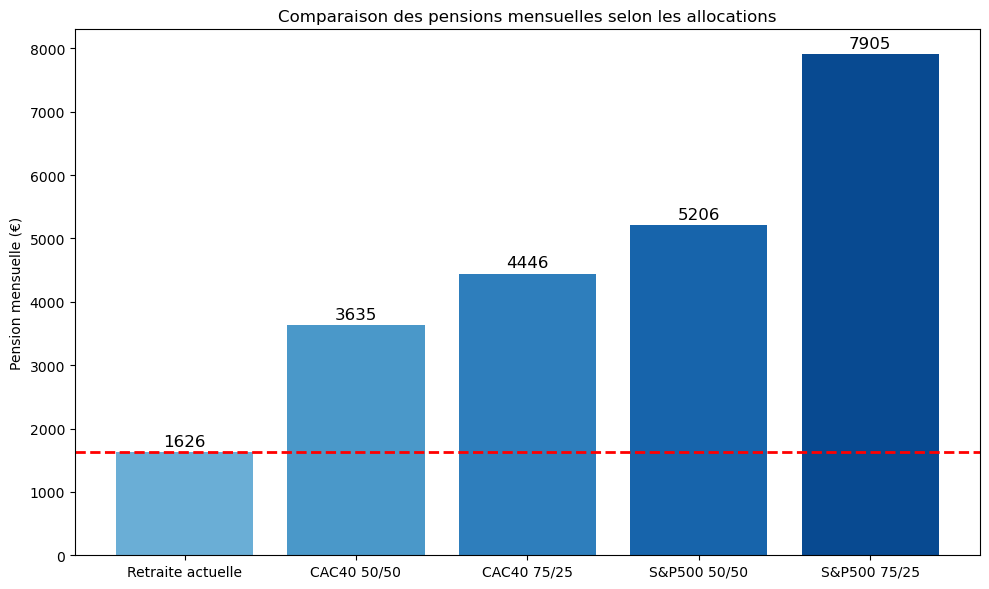

In [35]:
# Récupération des montants calculés
pensions = [retraite_actuelle, cac_50_50_solidaire, cac_75_25_solidaire, snp_50_50_solidaire, snp_75_25_solidaire]
allocations = ['Retraite actuelle', 'CAC40 50/50', 'CAC40 75/25', 'S&P500 50/50', 'S&P500 75/25']

# Création du graphique
plt.figure(figsize=(10,6))

# Appliquer une couleur plus harmonieuse avec un gradient de bleu
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(allocations)))  # Crée un gradient de bleu

# Générer les barres
bars = plt.bar(allocations, pensions, color=colors)

# Ajouter les labels au-dessus des barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50,  # Position du texte
             f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=12)  # Affichage du montant

# Ajouter la ligne de référence en pointillé rouge
plt.axhline(y=retraite_actuelle, color='red', linestyle='--', linewidth=2)

# Titre et labels
plt.title("Comparaison des pensions mensuelles selon les allocations")

plt.ylabel("Pension mensuelle (€)")
plt.tight_layout()

# Sauvegarde du graphique
plt.savefig("charts/comparaison_pensions_1.png", dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.show()

## 📌 Optimisation du taux de prélèvement

Nous avons choisi d’appliquer un **taux de prélèvement annuel uniforme de 9 %**, correspondant au **taux sécurisé** calculé pour l’allocation la moins performante de notre simulation.  
🔹 Ce taux est volontairement **prudent**, car il garantit que le capital accumulé reste suffisant pour couvrir **25 années de retraite**, en cohérence avec l’espérance de vie moyenne des retraités en France.

💡 Pour affiner l’analyse, nous avons également déterminé des **taux de retrait optimaux spécifiques à chaque allocation**.  
Ces taux tiennent compte de la performance réelle de chaque portefeuille et permettent de **maximiser les pensions** sans risque d’épuisement prématuré du capital.

➡️ Dans les cas où l’allocation est plus dynamique (par exemple avec une forte exposition au **S&P500**), un taux de prélèvement supérieur serait viable, conduisant à des **pensions plus élevées** que celles présentées ici à titre conservateur.



In [36]:
# Calcul du montant des cotisations
cac_50_50_pension_opti = (cac_50_50_final * cac40_50_50_swr / 12) - (cac_50_50_pension*taux_solidarité_dynamique)
cac_75_25_pension_opti = (cac_75_25_final * cac40_75_25_swr / 12) - (cac_50_50_pension*taux_solidarité_dynamique)
snp_50_50_pension_opti = (snp_50_50_final * snp500_50_50_swr / 12) - (cac_50_50_pension*taux_solidarité_dynamique)
snp_75_25_pension_opti = (snp_75_25_final * snp500_75_25_swr / 12) - (cac_50_50_pension*taux_solidarité_dynamique)

print("RESULTATS optimisés :")
print(f"pension mensuelle pour l'allocation CAC 40 / World Bonds 50/50 optimisée : {int(cac_50_50_pension_opti)}€")
print(f"pension mensuelle pour l'allocation CAC 40 / World Bonds 75/20 optimisée : {int(cac_75_25_pension_opti)}€")
print(f"pension mensuelle pour l'allocation S&P 500 / World Bonds 50/50 optimisée : {int(snp_50_50_pension_opti)}€")
print(f"pension mensuelle pour l'allocation S&P 500 / World Bonds 75/75 optimisée : {int(snp_75_25_pension_opti)}€")

RESULTATS optimisés :
pension mensuelle pour l'allocation CAC 40 / World Bonds 50/50 optimisée : 3634€
pension mensuelle pour l'allocation CAC 40 / World Bonds 75/20 optimisée : 4765€
pension mensuelle pour l'allocation S&P 500 / World Bonds 50/50 optimisée : 6207€
pension mensuelle pour l'allocation S&P 500 / World Bonds 75/75 optimisée : 10158€


In [37]:
# Dataframe des résultats
df_resultats = pd.DataFrame({"Allocation": ["Retraite médiane actuelle",
                                            "CAC 40 / World Bonds 50/50",
                                            "CAC 40 / World Bonds 75/25",
                                            "S&P 500 / World Bonds 50/50",
                                            "S&P 500 / World Bonds 75/75"],
                            "Pension mensuelle optimisée (€)": [int(1626),
                                                                int(cac_50_50_pension_opti),
                                                                int(cac_75_25_pension_opti),
                                                                int(snp_50_50_pension_opti),
                                                                int(snp_75_25_pension_opti)  ]  }  )

# Export en CSV
df_resultats.to_csv(r"data\final\resultats_pensions_optimisees.csv", index=False)

In [38]:
print(f"CAC40 50/50 Safe withdrawal : {cac40_50_50_swr:.2%}")
print(f"CAC40 75/25 Safe withdrawal : {cac40_75_25_swr:.2%}")
print(f"S&P500 50/50 Safe withdrawal : {snp500_50_50_swr:.2%}")
print(f"S&P500 75/25 Safe withdrawal : {snp500_75_25_swr:.2%}")

CAC40 50/50 Safe withdrawal : 9.07%
CAC40 75/25 Safe withdrawal : 9.72%
S&P500 50/50 Safe withdrawal : 10.81%
S&P500 75/25 Safe withdrawal : 11.65%


## 📌 Comparaison visuelle des pensions mensuelles – Version optimisée

Les graphiques suivants comparent les pensions mensuelles simulées pour chaque allocation de portefeuille avec la pension moyenne actuelle issue du système par répartition (**1 626 € bruts**).  
La ligne rouge représente ce niveau de référence.

Contrairement à la première version, les pensions affichées ici sont calculées à partir d’un **taux de retrait spécifique à chaque portefeuille**, optimisé en fonction de sa performance historique.  
Cela permet de refléter plus fidèlement le **potentiel réel** de chaque stratégie d’investissement dans un système de retraite par capitalisation.

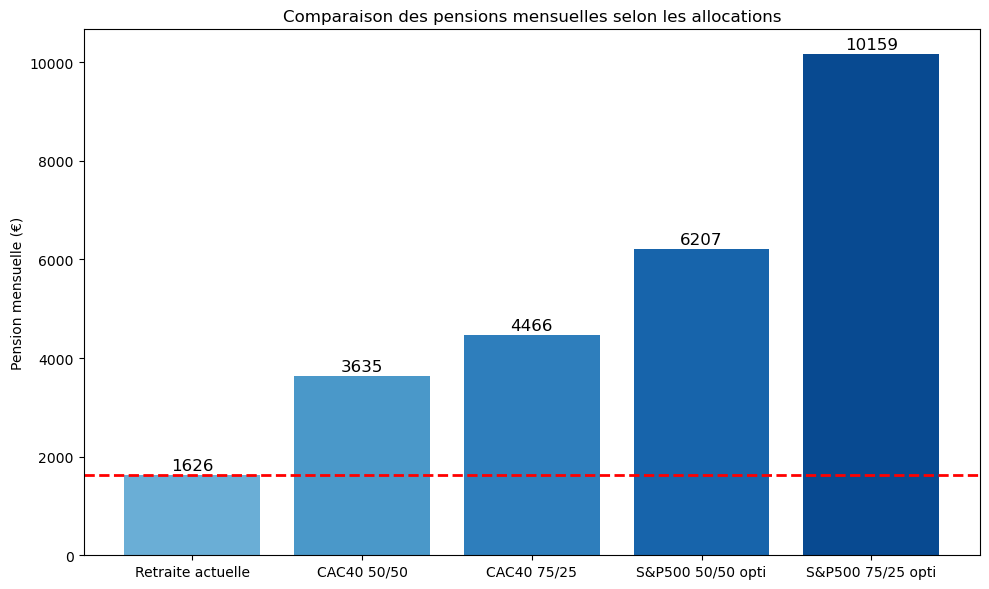

In [39]:
# Récupération des montants calculés
pensions = [retraite_actuelle, cac_50_50_solidaire, cac_75_25_pension, snp_50_50_pension_opti, snp_75_25_pension_opti]
allocations = ['Retraite actuelle', 'CAC40 50/50', 'CAC40 75/25', 'S&P500 50/50 opti', 'S&P500 75/25 opti']

# Création du graphique
plt.figure(figsize=(10,6))

# Appliquer une couleur plus harmonieuse avec un gradient de bleu
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(allocations)))  # Crée un gradient de bleu

# Générer les barres
bars = plt.bar(allocations, pensions, color=colors)

# Ajouter les labels au-dessus des barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50,  # Position du texte
             f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=12)  # Affichage du montant

# Ajouter la ligne de référence en pointillé rouge
plt.axhline(y=retraite_actuelle, color='red', linestyle='--', linewidth=2)

# Titre et labels
plt.title("Comparaison des pensions mensuelles selon les allocations")

plt.ylabel("Pension mensuelle (€)")
plt.tight_layout()

# Sauvegarde du graphique
plt.savefig("charts/comparaison_pensions_2.png", dpi=300, bbox_inches='tight')

# Affichage du graphique
plt.show()


C:\Users\Vincent\AppData\Local\Temp\ipykernel_23928\1367543169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=allocations, y=pensions, palette=palette)


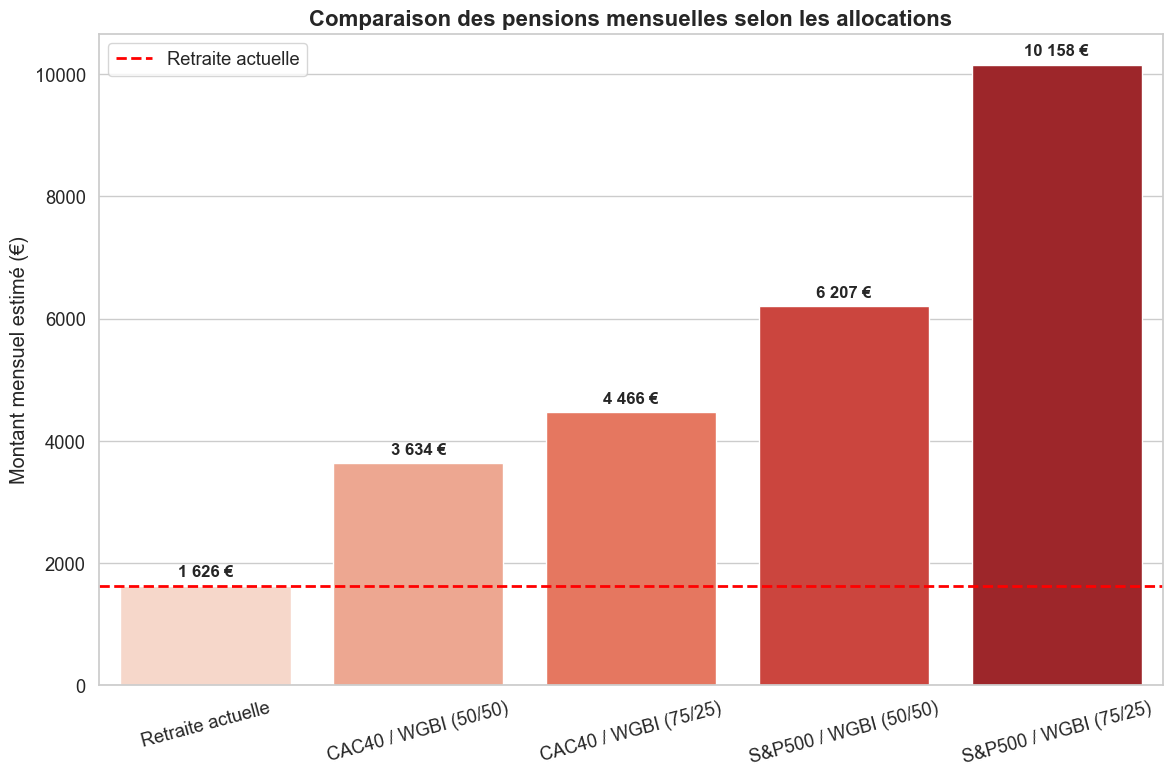

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Données
pensions = [retraite_actuelle, cac_50_50_solidaire, cac_75_25_pension, snp_50_50_pension_opti, snp_75_25_pension_opti]
allocations = ['Retraite actuelle', 'CAC40 / WGBI (50/50)', 'CAC40 / WGBI (75/25)', 'S&P500 / WGBI (50/50)', 'S&P500 / WGBI (75/25)']

# Setup Seaborn pour un style pro
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 8))

# Palette de couleurs avec dégradé bleu harmonieux
palette = sns.color_palette("Reds", len(allocations))

# Création du barplot
ax = sns.barplot(x=allocations, y=pensions, palette=palette)

# Ajouter les montants au-dessus de chaque barre
for i, bar in enumerate(ax.patches):
    value = pensions[i]
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(pensions) * 0.01,  # Ajuste dynamiquement la hauteur du texte
            f'{int(value):,} €'.replace(',', ' '),  # Format français avec espaces
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Ligne de référence pour la retraite actuelle
plt.axhline(y=retraite_actuelle, color='red', linestyle='--', linewidth=2, label='Retraite actuelle')

# Titre et axes
plt.title("Comparaison des pensions mensuelles selon les allocations", fontsize=16, fontweight='bold')
plt.ylabel("Montant mensuel estimé (€)")
plt.xlabel("")
plt.xticks(rotation=15)

# Légende + marges
plt.legend()
plt.tight_layout()

# Sauvegarde HD
plt.savefig("charts/comparaison_pensions_red.png", dpi=300, bbox_inches='tight')

# Affichage
plt.show()


## 📌 Calcul des coefficients multiplicateurs

Pour terminer, et afin d’illustrer l’écart significatif entre les différents scénarios, nous calculons les **coefficients multiplicateurs** des pensions issues de chaque allocation par rapport à la **pension moyenne brute actuelle** du système par répartition (1 626 €).

🔹 Ces coefficients indiquent de combien la pension aurait été **multipliée** dans un système par capitalisation, selon l’allocation choisie.

Cela permet de visualiser très simplement le **gain potentiel** offert par un modèle capitalisé sur le long terme.

In [41]:
# Calcul des multiples
multiple_cac_50_50 = cac_50_50_pension / retraite_actuelle
multiple_cac_75_25 = cac_75_25_pension / retraite_actuelle
multiple_cac_75_25_opti = cac_75_25_pension_opti / retraite_actuelle
multiple_snp_50_50 = snp_50_50_pension / retraite_actuelle
multiple_snp_50_50_opti = snp_50_50_pension_opti / retraite_actuelle
multiple_snp_75_25 = snp_75_25_pension / retraite_actuelle
multiple_snp_75_25_opti = snp_75_25_pension_opti / retraite_actuelle

# Affichage des résultats
print(f"Multiple CAC40 50/50 : --------- x{multiple_cac_50_50:.2f}")
print(f"Multiple CAC40 75/25 : --------- x{multiple_cac_75_25:.2f}")
print(f"Multiple CAC40 75/25 optimisé :  x{multiple_cac_75_25_opti:.2f}")
print(f"Multiple S&P500 50/50 : -------- x{multiple_snp_50_50:.2f}")
print(f"Multiple S&P500 50/50 optimisé : x{multiple_snp_50_50_opti:.2f}")
print(f"Multiple S&P500 75/25 : -------- x{multiple_snp_75_25:.2f}")
print(f"Multiple S&P500 75/25 optimisé : x{multiple_snp_75_25_opti:.2f}")

Multiple CAC40 50/50 : --------- x2.25
Multiple CAC40 75/25 : --------- x2.75
Multiple CAC40 75/25 optimisé :  x2.93
Multiple S&P500 50/50 : -------- x3.21
Multiple S&P500 50/50 optimisé : x3.82
Multiple S&P500 75/25 : -------- x4.87
Multiple S&P500 75/25 optimisé : x6.25


## **📌 Présentation des résultats**
Les résultats montrent que **toutes les allocations capitalisées surpassent largement le niveau des pensions actuelles**.  
Cette étude démontre qu’un **système de capitalisation bien structuré** aurait pu offrir des retraites **nettement supérieures** à celles du système actuel par répartition.

📌 **Observations clés** :\
✔️ **Le CAC40 seul offre déjà de meilleures pensions que le système actuel**, même sans effet de capitalisation massive.  
✔️ **Les allocations exposées au S&P500 produisent des pensions jusqu’à 6 fois plus élevées**, confirmant l’intérêt d’un modèle de capitalisation performant.  
✔️ **Même en intégrant un mécanisme de solidarité**, le système reste latgement plus soutenable qu’une répartition classique.


💡 **Ces résultats permettent d’ouvrir la discussion sur une réforme possible du financement des retraites en France.**

## 📌 Présentation des résultats

Les résultats montrent que **toutes les allocations capitalisées surpassent largement le niveau des pensions actuelles**.  
Cette étude démontre qu’un **système de capitalisation bien structuré** aurait pu offrir des retraites **nettement supérieures** à celles du système actuel par répartition.

### 📌 Observations clés :
✔️ **Le CAC40 seul offre déjà de meilleures pensions que le système actuel**, même sans bénéficier d’un effet de capitalisation massif.  
✔️ **Les allocations exposées au S&P500 produisent des pensions jusqu’à 6 fois plus élevées**, confirmant l’intérêt d’un modèle performant à long terme.  
✔️ **Même en intégrant un mécanisme de solidarité**, le système reste largement plus soutenable qu’une répartition classique.



💡 Il est essentiel de souligner que cette étude se concentre principalement sur le **niveau des pensions obtenues**, mais **le véritable atout d’un système par capitalisation va bien au-delà**.

### ✅ Un modèle structurellement viable

Contrairement au système par répartition, où les pensions des retraités dépendent directement des cotisations des actifs en temps réel, un modèle capitalisé repose **exclusivement sur l’effort individuel d’épargne et de cotisation**.  
Cela le rend **structurellement indépendant** :

- **Pas de dépendance à la démographie** (rapport actifs/retraités),
- **Pas de fragilité face au ralentissement économique ou à la baisse de la natalité**,
- **Pas de nécessité d’ajustements permanents via des réformes impopulaires**.

Chaque individu finance sa retraite en constituant **son propre capital**, ce qui rend le système à la fois **prévisible**, **équitable** et **pérenne**.

---

📌 **Ces résultats ouvrent la voie à une réflexion approfondie sur les fondements du financement des retraites en France**, et sur la possibilité d’introduire un **modèle hybride**, combinant **efficacité économique** et **solidarité ciblée**.

---

🗣️ **Ouvert aux remarques et discussions constructives**  
Ce travail est une première base de réflexion et reste perfectible. Toute remarque, critique ou suggestion permettant d’enrichir le modèle ou d’ouvrir de nouvelles pistes d’analyse est la bienvenue.